# Build a compare view

Requires:
- Two VTK files for a given timestep
- A line segment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import os, subprocess, pickle
import pickle

In [2]:
REPO_PATH = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('utf-8').strip()
plt.style.use(f'{REPO_PATH}/misc/edwin.mplstyle')

In [3]:
## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
#pv.set_jupyter_backend('ipygany')
pv.global_theme.transparent_background = False
pv.global_theme.show_scalar_bar = True

In [4]:
isHot  = False
isRiver = False

if (isRiver):
    ## Paths to DOC = 5mg/L
    if (isHot):
        ## With hot-start
        RASfile = ""
        LESfile  = ""
    else:
        ## Without hot-start
        RASfile = ""
        LESfile  = ""

else:
    ## Paths to DOC = 20mg/L 
    if (isHot):
        ## With hot-start (after 299 timesteps (3600s each)) 
        RASfile = "/home/edsaa/nuModel/tempBioreactions/2.0NonZeroRANS/2.0NonZeroInitCondition/VTK/2.0NonZeroInitCondition_10560.vtk"
        LESfile  = "/home/edsaa/nuModel/tempBioreactions/2.1LES/2.1NonZeroLESRun/VTK/2.1NonZeroLESRun_32631200.vtk"
    else:
        ## Without hot-start (after 318 timesteps (3600s each))
        RASfile = "/home/edsaa/nuModel/tempBioreactions/2.3ZeroStartRANS/2.3ZeroRANS/VTK/2.3ZeroRANS_7608.vtk"
        LESfile  = "/home/edsaa/nuModel/tempBioreactions/2.2ZeroLES/2.2ZeroLES/VTK/2.2ZeroLES_23509296.vtk"

In [5]:
RASgrid = pv.read(RASfile)
LESgrid = pv.read(LESfile)

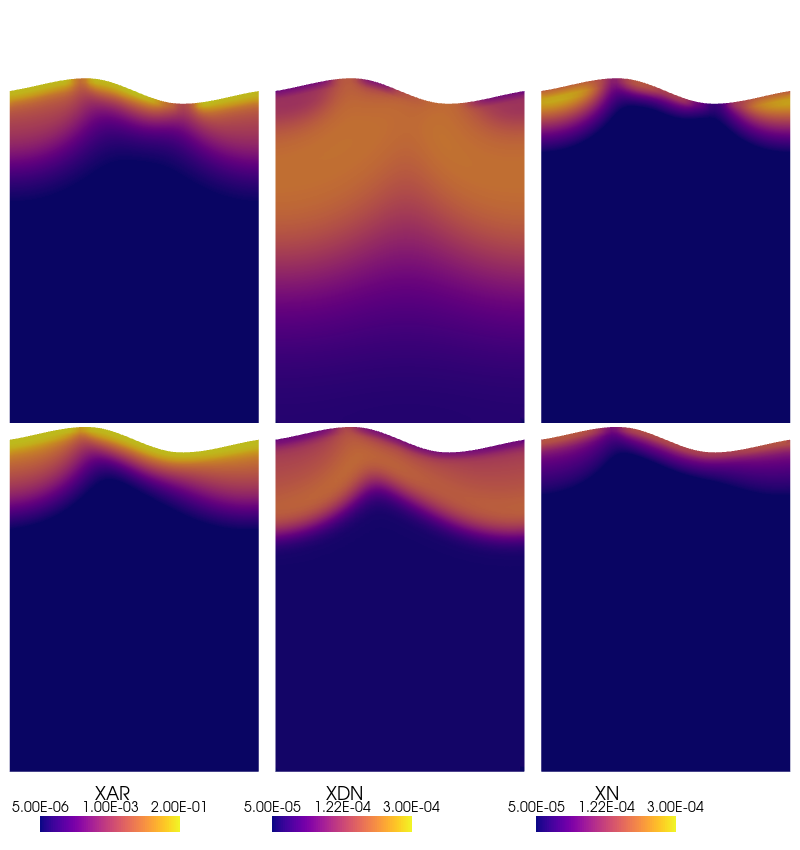

In [19]:
colorbar_kw = dict(width=0.18, height=0.05, position_y=0.02, fmt='%.2E', label_font_size=14, n_labels=3)
addmesh_kw  = dict(log_scale=True, cmap='plasma', show_scalar_bar=True)
fileForPNG = "CompareMicrobialFields.png"

plotter = pv.Plotter(window_size=[800,850])

clim_arg = dict(xar = (5E-6,2E-1), xdn = (5E-5,3E-4), xn = (5E-5,3E-4))

#@@@@@@@@@@@@@@ RANS
colorbar_kw['position_x'] = 0.05
slice_xar_ras = RASgrid.slice(normal='z')
slice_xar_ras.set_active_scalars('XAR',preference='point')
plotter.add_mesh(slice_xar_ras, scalars='XAR', clim=clim_arg['xar'],
                 scalar_bar_args=colorbar_kw, **addmesh_kw)

colorbar_kw['position_x'] = 0.34
slice_xdn_ras = RASgrid.slice(normal='z')
slice_xdn_ras.translate((0.16, 0, 0), inplace=True)
slice_xdn_ras.set_active_scalars('XDN',preference='point')
plotter.add_mesh(slice_xdn_ras, scalars='XDN', clim=clim_arg['xdn'],
                 scalar_bar_args=colorbar_kw, **addmesh_kw)

colorbar_kw['position_x'] = 0.67
slice_xn_ras = RASgrid.slice(normal='z')
slice_xn_ras.translate((0.32, 0, 0), inplace=True)
slice_xn_ras.set_active_scalars('XN',preference='point')
plotter.add_mesh(slice_xn_ras, scalars='XN', clim=clim_arg['xn'],
                 scalar_bar_args=colorbar_kw, **addmesh_kw)

#@@@@@@@@@@@@ LES
addmesh_kw['show_scalar_bar'] = False

slice_xar_les = LESgrid.slice(normal='z')
slice_xar_les.translate((0, -0.21, 0), inplace=True)
slice_xar_les.set_active_scalars('XAR',preference='point')
plotter.add_mesh(slice_xar_les, scalars='XAR', clim=clim_arg['xar'],
                 **addmesh_kw)

slice_xdn_les = LESgrid.slice(normal='z')
slice_xdn_les.translate((0.16, -0.21, 0), inplace=True)
slice_xdn_les.set_active_scalars('XDN',preference='point')
plotter.add_mesh(slice_xdn_les, scalars='XDN', clim=clim_arg['xdn'],
                 **addmesh_kw)

slice_xn_les = LESgrid.slice(normal='z')
slice_xn_les.translate((0.32, -0.21, 0), inplace=True)
slice_xn_les.set_active_scalars('XN',preference='point')
plotter.add_mesh(slice_xn_les, scalars='XN', clim=clim_arg['xn'],
                 **addmesh_kw)

plotter.view_xy()
plotter.enable_parallel_projection()
plotter.camera.zoom(1.3)

# Save file as PNG
fileForPNG = f"CompareMicrobialFields/{isHot=}_{isRiver=}.png"
plotter.screenshot(fileForPNG,transparent_background=True);

## Copy to clipboard
# os.system(f"xclip -se c -t image/png -i {fileForPNG}")
plotter.show()

## Create a depth profile on immobile species

In [7]:
xLineCoord = 0.01
RASLine = RASgrid.sample_over_line(
    (xLineCoord, RASgrid.bounds[2], 0.1),
    (xLineCoord, RASgrid.bounds[3], 0.1),
    resolution=100)

LESLine = LESgrid.sample_over_line(
    (xLineCoord, LESgrid.bounds[2], 0.1),
    (xLineCoord, LESgrid.bounds[3], 0.1),
    resolution=100)

RASdepth = np.where(RASLine['vtkValidPointMask'],RASLine['Distance'],np.NaN)
LESdepth = np.where(LESLine['vtkValidPointMask'],LESLine['Distance'],np.NaN)

In [8]:
listOfSpecies = ['O2','DOC','NO3','NH4']

listOfAliveBiomass = ['XAR','XN','XDN']
biomassColors = ['darkgrey','darkorange','green']

listOfDeadBiomass  = ['EPS','XI']

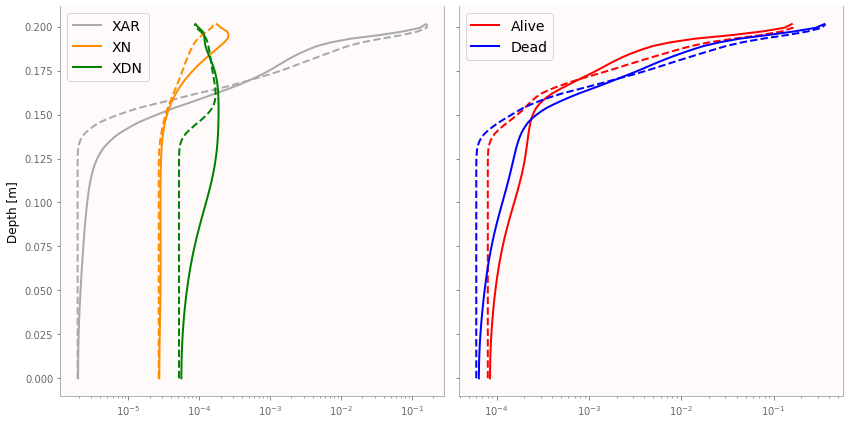

In [9]:
fig,axs = plt.subplots(1,2,sharey=True,figsize=[12,6])

ax = axs[0]
for bio,color in zip(listOfAliveBiomass,biomassColors):
    ax.plot(RASLine[bio],RASdepth,label=bio,c=color)
    ax.plot(LESLine[bio],LESdepth,ls='dashed',c=color)
ax.set(xscale='log')
ax.legend()

ax = axs[1]
RASalive = RASLine['XAR'] + RASLine['XN'] + RASLine['XDN']
RASdead  = RASLine['EPS'] + RASLine['XI']

LESalive = LESLine['XAR'] + LESLine['XN'] + LESLine['XDN']
LESdead  = LESLine['EPS'] + LESLine['XI']

ax.plot(RASalive,RASdepth,label='Alive',c='r')
ax.plot(LESalive,LESdepth,ls='dashed',c='r')

ax.plot(RASdead,RASdepth,label='Dead',c='b')
ax.plot(LESdead,LESdepth,ls='dashed',c='b')
ax.set(xscale='log')
ax.legend()

fig.supylabel('Depth [m]')
fig.tight_layout()

#fileForPNG = (vtkfile.split('/')[-1]).split('.')[0] + ".png"
#plt.savefig(fileForPNG)
plt.show()
#os.system(f"xclip -se c -t image/png -i {fileForPNG}")
